In [34]:
# Chapter 6 ツール呼び出しエージェントの構築
"""LangGraphとTavilyを使用して、ツールの呼び出しを動的に判断するエージェントを作成しましょう。"""

# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [35]:
# Chapter 6.2 検索ツールの定義
"""Tavilyを使用してWeb検索を行うツールを定義します。LangChainにはTavily用のツール TavilySearchResults が用意されています。"""

# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [36]:
# 動作確認
"""Web検索ツールの動作確認を行いましょう。"""
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://medium.com/pythoneers/building-ai-agent-systems-with-langgraph-9d85537a6326',
  'content': 'LangGraph is a library built on top of LangChain, designed to create cyclic graphs for LLM-based AI agents.\n It enables cyclic graph topologies for workflows, allowing more flexible and nuanced agent behaviors than linear models.\n Utilizes key elements:  \n   — Nodes: Represent functions or LangChain runnable items.  \n   — Edges: Define execution and data flow.  \n   — Stateful graphs: Manage persistent data across execution cycles. [...] State maintains and updates the context or memory as the process advances and enabling each step to access relevant information from earlier steps for dynamic decision-making.\n Nodes represent individual computation steps or tasks, performing specific functions like data processing, decision-making or system interactions. [...] The diagram illustrates how LangGraph facilitates a dynamic, cyclic workflow for AI agents. The process begins wi

In [37]:
# Chapter 6.3
"""
ステートグラフの作成とチャットボットノードの追加
LangGraphの基本で行ったように、ステートグラフの作成とチャットボットノードの追加を行いましょう。
"""
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

In [38]:
# Chapter 6.4 ツールノードの追加
"""グラフにツールノードを追加して、記憶を持つ実行可能なステートグラフを作成します。"""
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
"""
add_conditional_edges で条件付エッジを作成します。
・“chatbot”：第一引数には、遷移元のノードを指定します。
・tools_condition：第二引数には、ルーティングを行う関数を指定します。
  tools_condition はLangChainで用意されている関数で、”chatbot” ノードからの出力に "tool_calls" があるときは "tools" を返し、それ以外の時は "__end__" を返します。
  これにより、ツール呼出と判断したらツールノードを呼ぶことが可能になります。
"""
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

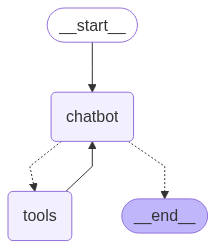

In [39]:
# ステートグラフの可視化
"""作成したステートグラフを可視化して確認しましょう。"""
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
# Chapter 6.5 動作確認
"""グラフを実行して動作確認を行いましょう。LangGraphの基本で行ったように、結果をストリーミングで得るチャットボットシステムを作成します。"""
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)
    print()  # 回答がすべて表示された後に改行します

こんにてゃ
こんにちは！今日はどんなことをお話ししましょうか？
台湾観光について検索結果を教えて

[{"url": "https://www.knt.co.jp/travelguide/kaigai/027/", "content": "国内\n\n海外\n\n台湾・台北観光のおすすめスポット19選！\n\n台湾・台北のツアーを日付・条件から探す\n\n台湾は日本から直行便で約4時間ほどで行ける人気の観光地。週末や連休を利用して気軽に行ける台湾は、グルメや観光、写真映えスポット、ショッピングなど幅広く楽しむことができます。国立故宮博物院や中正紀念堂など台湾の歴史あふれるエリア、若者に人気のショッピングエリアをはじめ、台北から少し足を伸ばせば、ノスタルジックな雰囲気と海を一望できる風光明媚な街並みが広がる九份があります。今回は台北を訪れたら絶対にチェックしておきたいスポットをご紹介します。\n\n目次\n\n【台北定番の観光スポット】\n\n高さ約509ｍを誇る台湾の街のシンボルタワー「台北101」\n\n世界四大博物館の1つ「国立故宮博物院」\n\n台北市で最大規模を誇る「士林観光夜市」\n\n美食がそろう夜市「饒河街観光夜市」\n\n台湾の歴史を象徴する場所「国立中正紀念堂」\n\nレトロな街並みが残る「迪化街」\n\n台湾のベニスと呼ばれる港町「淡水」\n\n商売繁盛の神様をまつる伝統的な廟「行天宮」\n\n英霊をまつる神聖な場所「忠烈祠」\n\n名店がずらりと並ぶ「永康街」"}, {"url": "https://www.hankyu-travel.com/guide/taiwan/", "content": "Image 10: 彩虹眷村彩虹眷村\n\n絶景にグルメ、ショッピング、温泉まで楽しめる台湾。台北のシンボルタワー、台北101でショッピングや眺望を楽しんだり、夜は寧夏夜市でB級グルメ三昧。足をのばして、九份の街歩きもおすすめです。そんな台湾の基本情報から観光情報まで詳しく紹介します。\n\n   観光マップ\n   おすすめ 観光スポット\n   グルメ\n   基本情報（ビザ・現地情報）\n\n台湾観光マップ\n\nMap\n\n   九份\n   台北\n   台中\n   台南\n   高雄\n\n台湾のおすすめ観光スポット総合ランキング\n